### Ensemble Methods Section 35

### Questions

### Objectives
YWBAT
- Compare and contrast decision trees with Random Forest Models
- Compare and contrast ADABoost with Gradient Boosting
- Condition our data for a single model
- Tune hyperparameters to increase desired metric
- Analyze model for use case
- Build a pipeline that will analyze an individual patient

### Outline
- Random Forests
- Adaboost and Gradient Boosted Random Forests
- Load in a dataset and try to solve the problem using Forest classifiers

### What is a random forest?
A random forest is a collection of decision trees where each decision tree is built by:
- random set of parameters
- similar tree hyperparameters 
    - maybe you can randomize each trees hyperparameters


How is a point assigned a label in a random forest?
- Each decision tree assigns a point a label
- The labels are then counted and the max count wins


### Pros and Cons
Pros
- Interpretability
    - you can interpret individual trees
    - strong performance
    - random sampling of features to reduce impact of strong features
        - prevents overfitting 
    - useful for datasets with high dimensionality of features
        - each tree is now reduced to a smaller dimension
        - you might miss important feature signals
    - good for small sample sizes because of bootstrap aggregation
        - more resilient to high variance

Cons
- Computationally expensive
- Greedy forests can occur if you sample too many features from your feature set on each tree
- Tree depth can cause greediness


### Real Life Structures


### Analyze 

### Adaboosting - sampling
* Adaptive Boosting
    * Weak Learners are adapting to previously misclassified data
* We're building a complex tree using stumps which are trees with 1 feature and 1 split
    
![](images/adaboost.jpg)



### Gradient boosting - residuals
* Building trees that fit on the residuals

![](images/gradboost.png)

### to use XGBOOST use
```import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'```

### Outline

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### Let's build some models

In [2]:
df = pd.read_csv("./churn.csv")
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,2845,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null int64
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null int64
international_plan               5000 non-null int64
voice_mail_plan                  5000 non-null int64
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes               

In [4]:
df.isna().sum()

state                            0
account_length                   0
area_code                        0
phone_number                     0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
class                            0
dtype: int64

### Count your labels

In [5]:
df["class"].value_counts()

0    4293
1     707
Name: class, dtype: int64

### we have unbalanced data, which is bad

In [6]:
df2 = df.drop(columns=["phone_number", "number_vmail_messages", "state", "area_code"])
df2.head()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,128,0,1,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [7]:
df2.corr()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
account_length,1.000000,0.014681,-0.006650,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.000656,0.001291,0.014277,0.001292,-0.001445,0.021203
international_plan,0.014681,1.000000,0.009054,0.028138,0.008102,0.028141,0.021235,0.002505,0.021234,-0.026508,0.005623,-0.026510,0.031799,0.004493,0.031751,-0.012974,0.259123
voice_mail_plan,-0.006650,0.009054,1.000000,0.002059,-0.001735,0.002056,0.023328,-0.005916,0.023332,0.005524,0.009176,0.005522,0.004116,-0.007525,0.004165,-0.014453,-0.110698
total_day_minutes,-0.001017,0.028138,0.002059,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,0.011783,-0.019486,-0.001303,-0.019415,0.002733,0.207705
total_day_calls,0.028240,0.008102,-0.001735,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.002802,0.013097,0.010893,0.013161,-0.010739,0.016130
total_day_charge,-0.001019,0.028141,0.002056,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,0.011785,-0.019490,-0.001307,-0.019419,0.002726,0.207700
total_eve_minutes,-0.009591,0.021235,0.023328,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,-0.016642,0.000137,0.008388,0.000159,-0.013823,0.089288
total_eve_calls,0.009143,0.002505,-0.005916,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,0.001799,-0.007458,0.005574,-0.007507,0.006235,-0.006284
total_eve_charge,-0.009587,0.021234,0.023332,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,-0.016652,0.000132,0.008393,0.000155,-0.013836,0.089282
total_night_minutes,0.000668,-0.026508,0.005524,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,0.999999,-0.006721,-0.017214,-0.006655,-0.008533,0.045677


### Let's build a out of box random forest

In [8]:
clf = RandomForestClassifier(criterion='entropy', max_depth=5)

In [34]:
X, y = df2.drop("class", axis=1), df["class"]

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.70)

In [36]:
clf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
clf.score(xtest, ytest)

0.9273333333333333

In [38]:
ytest_preds = clf.predict(xtest)

In [39]:
confusion_matrix(ytest, ytest_preds)

array([[1300,    4],
       [ 105,   91]])

### How do we deal with imbalanced data? 

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
smote = SMOTE()

In [42]:
xtrain_smote, ytrain_smote = smote.fit_resample(xtrain, ytrain)

/Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [43]:
xtrain.shape, xtrain_smote.shape

((3500, 16), (5978, 16))

In [44]:
np.bincount(ytrain), np.bincount(ytrain_smote)

(array([2989,  511]), array([2989, 2989]))

### Now that that's over...let's make a random forest on our synthesized data

In [75]:
clf = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4)
clf.fit(xtrain_smote, ytrain_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
clf.score(xtest, ytest)

ytest_preds = clf.predict(xtest)

In [77]:
confusion_matrix(ytest, ytest_preds)

array([[1174,  130],
       [  36,  160]])

### Now let's look at feature importances in our model

In [78]:
feature_scores = clf.feature_importances_
features = xtrain.columns

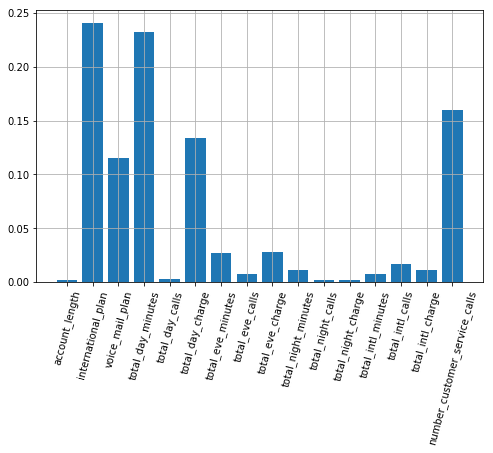

In [79]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.bar(features, feature_scores)
plt.xticks(rotation=75)
plt.show()

In [80]:
df2['ones'] = np.ones(shape=(df.shape[0], 1))
df2.head()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class,ones
0,128,0,1,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,1.0
1,107,0,1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,1.0
2,137,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,1.0
3,84,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1.0
4,75,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,1.0


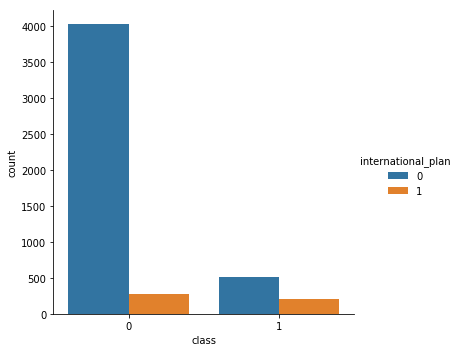

In [81]:
sns.catplot(x='class', hue='international_plan', kind='count', data=df2)
plt.show()

### how do we look at a tree? 

In [85]:
tree0 = clf.estimators_[12]

In [86]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import pydotplus

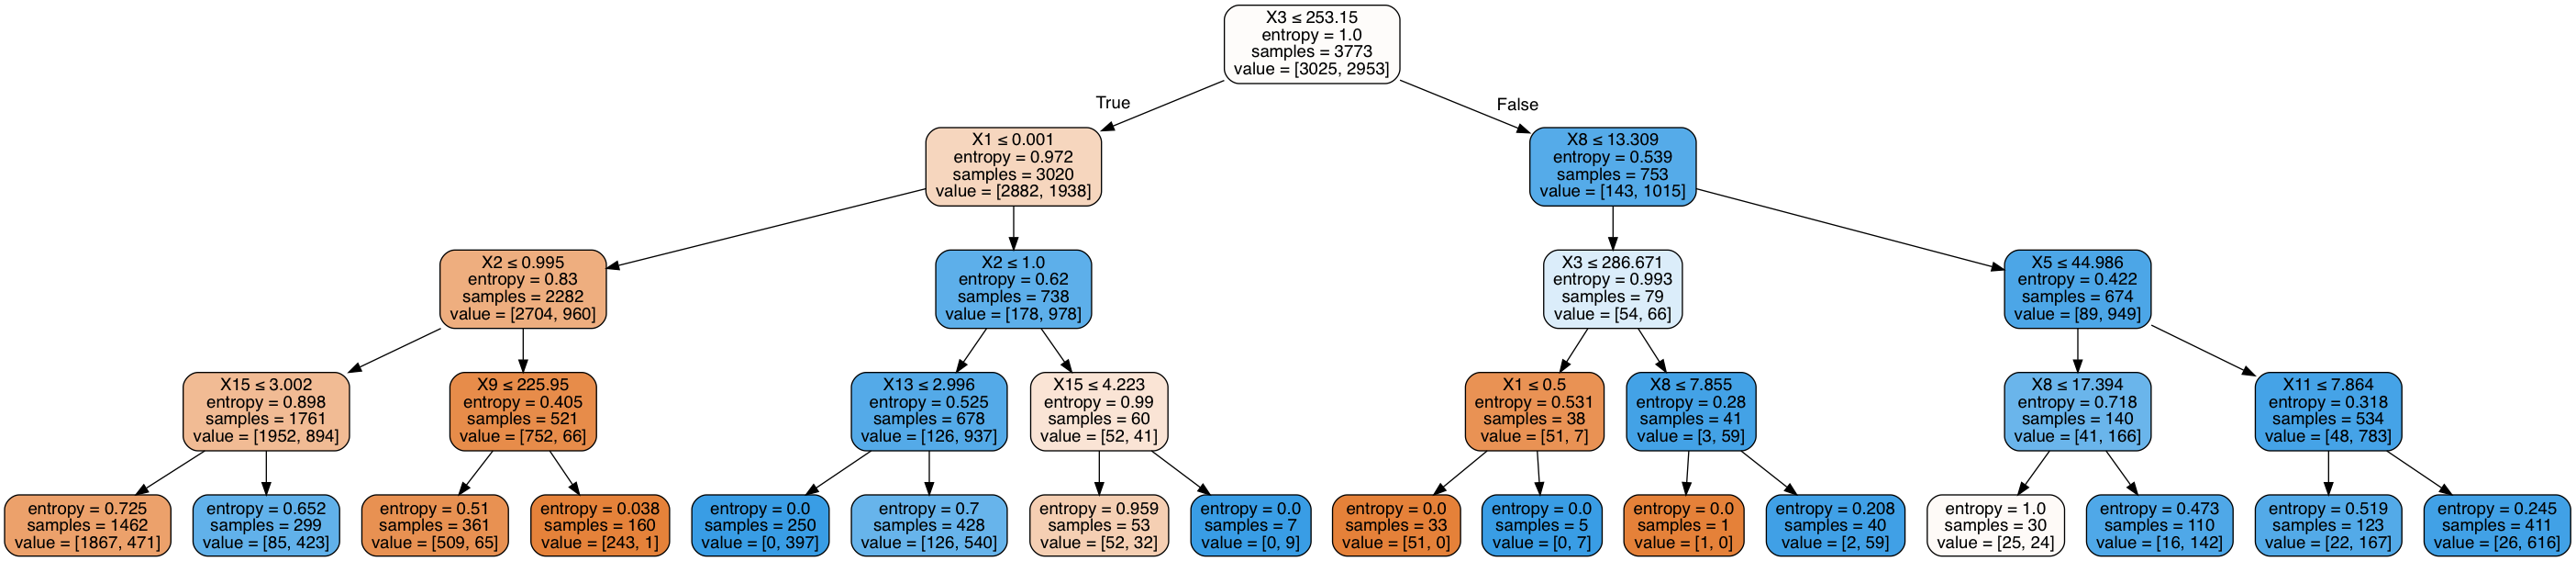

In [87]:
dot_data = StringIO()
export_graphviz(tree0, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [88]:
clf = AdaBoostClassifier(n_estimators=20)

In [90]:
clf.fit(xtrain_smote, ytrain_smote)
clf.score(xtest, ytest)

0.8753333333333333

In [91]:
confusion_matrix(ytest, clf.predict(xtest))

array([[1172,  132],
       [  55,  141]])

In [103]:
clf = GradientBoostingClassifier(learning_rate=1.0, n_estimators=20)
clf.fit(xtrain_smote, ytrain_smote)
print(clf.score(xtest, ytest))
confusion_matrix(ytest, clf.predict(xtest))

0.9426666666666667


array([[1263,   41],
       [  45,  151]])

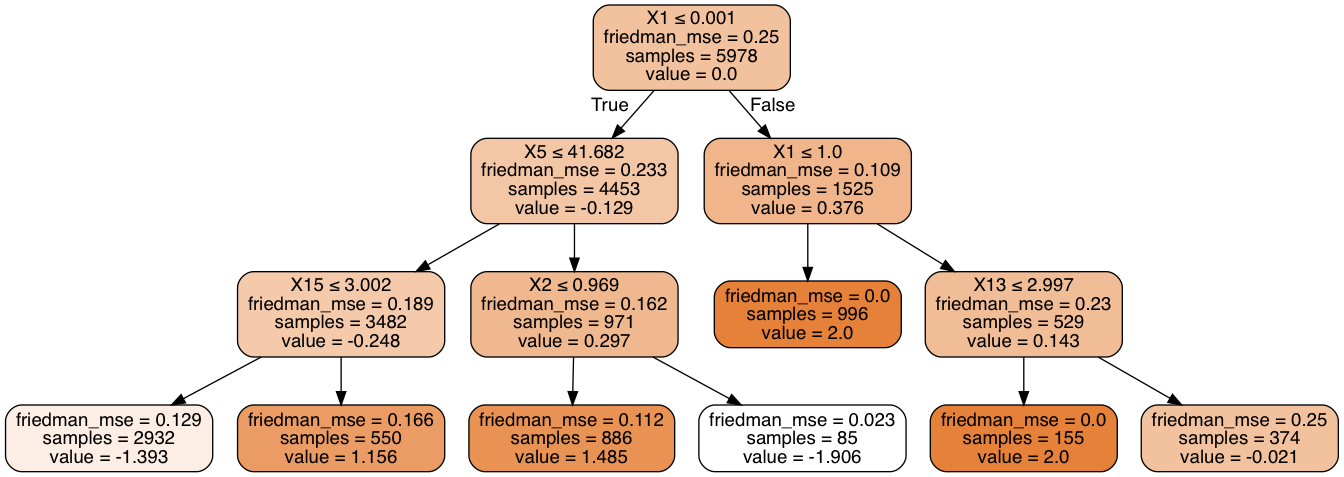

In [104]:
tree0 = clf.estimators_[0][0]
dot_data = StringIO()
export_graphviz(tree0, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [105]:
tree0

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=<mtrand.RandomState object at 0x10e0b4798>,
                      splitter='best')